In [831]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from sklearn.metrics import classification_report

In [832]:
#importing the data
df_path = osp.abspath("display_training.csv")
df = pd.read_csv(df_path)

In [833]:
#Accoording to the display data dictionary,and the prompt it was my understanding that the individuals are to be exposed to 
# the display add, and then take the survey, however when the time difference was calculated I found a few negative numbers
#meaning that the survey seemed to be taken before seeing the ad, so those were removed.
df['survey_date'] = pd.to_datetime(df['survey_date'])
df['ts_collector_min'] = pd.to_datetime(df['ts_collector_min'])
df['ts_collector_min'] = pd.to_datetime(df['ts_collector_min'])
df['time_diff']= df['survey_date']-(df['ts_collector_min'])
df['correct_order']= df['survey_date']>(df['ts_collector_min'])
df[['ts_collector_min', 'survey_date', 'time_diff', 'correct_order']]

,ts_collector_min,survey_date,time_diff,correct_order
0,2021-02-23 00:44:00,2021-02-23 16:09:00,0 days 15:25:00,True
1,2021-02-23 00:45:00,2021-02-23 16:09:00,0 days 15:24:00,True
2,2021-02-23 19:29:00,2021-02-23 16:09:00,-1 days +20:40:00,False
3,2021-02-18 20:24:00,2021-02-23 16:10:00,4 days 19:46:00,True
4,2021-02-22 02:19:00,2021-02-23 16:08:00,1 days 13:49:00,True
...,...,...,...,...
106400,2021-10-30 15:12:00,2021-11-01 00:00:00,1 days 08:48:00,True
106401,2021-10-31 20:05:00,2021-11-01 00:00:00,0 days 03:55:00,True
106402,2021-10-31 20:05:00,2021-11-01 00:00:00,0 days 03:55:00,True
106403,2021-10-31 20:05:00,2021-11-01 00:00:00,0 days 03:55:00,True


In [834]:
#Here is where the negative values from the time difference were dropped
df.drop(df[df['survey_date'] < df['ts_collector_min']].index, inplace = True)
df['correct_order']


0         True
1         True
3         True
4         True
6         True
          ... 
106400    True
106401    True
106402    True
106403    True
106404    True
Name: correct_order, Length: 104594, dtype: bool

In [835]:
#I then changed the time_diff to be formatted in total seconds to make it easier to compare.
df['time_diff']=(df['time_diff'].dt.total_seconds())

In [836]:
df.head(5)

,respondent_id,survey_date,recall,aided_awareness,unaided_awareness_any,familiarity,consideration,favorability,intent,session_id,...,time_50,time_60,time_66,time_70,time_75,time_80,time_90,time_100,time_diff,correct_order
0,603589e7-06e9-f826-35d8-ed1909ce1daf,2021-02-23 16:09:00,0.0,NaN,0.0,NaN,0.00,NaN,NaN,f1cbd2f8-48a8-44f0-8bfc-799513a32a61,...,21.134,21.134,21.134,21.134,21.134,21.134,21.134,21.134,55500.0,True
1,603589e7-06e9-f826-35d8-ed1909ce1daf,2021-02-23 16:09:00,0.0,NaN,0.0,NaN,0.00,NaN,NaN,fd30d0ec-deb2-4e2b-8cd4-eadc83508cfc,...,3.350,3.350,3.350,3.350,3.350,3.350,3.350,3.350,55440.0,True
3,603589fe-842a-ded3-29e6-3606156e1c2f,2021-02-23 16:10:00,0.0,NaN,0.0,NaN,0.25,NaN,NaN,a71a60ea-b0dd-4433-bae4-de121ca612ed,...,11.610,11.610,11.610,11.610,3.174,3.174,3.174,1.770,416760.0,True
4,60358a5a-1ee3-9e61-1df6-241ff9e18697,2021-02-23 16:08:00,0.0,NaN,0.0,NaN,0.75,NaN,NaN,e6adf80c-8a7a-4fd4-9ebe-8e6f0caa8059,...,9.056,9.056,9.056,9.056,9.056,9.056,9.056,2.273,136140.0,True
6,60358ad6-62ec-f38a-374f-10bb936d6392,2021-02-23 16:11:00,0.0,NaN,0.0,NaN,0.00,NaN,NaN,c7427ddb-e02c-4bf9-8f1b-f613c2e2b006,...,0.767,0.767,0.767,0.767,0.767,0.767,0.767,0.767,1185060.0,True


In [837]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104594 entries, 0 to 106404
Data columns (total 38 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   respondent_id          104594 non-null  object        
 1   survey_date            104594 non-null  datetime64[ns]
 2   recall                 104577 non-null  float64       
 3   aided_awareness        100180 non-null  float64       
 4   unaided_awareness_any  101286 non-null  float64       
 5   familiarity            86174 non-null   float64       
 6   consideration          90127 non-null   float64       
 7   favorability           87655 non-null   float64       
 8   intent                 3308 non-null    float64       
 9   session_id             104594 non-null  object        
 10  ts_collector_min       104594 non-null  datetime64[ns]
 11  device_type            104594 non-null  object        
 12  device_screen_height   104594 non-null  int6

In [838]:
print(df.shape)
df.describe()

(104594, 38)


,recall,aided_awareness,unaided_awareness_any,familiarity,consideration,favorability,intent,device_screen_height,device_screen_width,ad_area,...,time_40,time_50,time_60,time_66,time_70,time_75,time_80,time_90,time_100,time_diff
count,104577.000000,100180.000000,101286.000000,86174.000000,90127.000000,87655.000000,3308.000000,104594.000000,104594.000000,1.045940e+05,...,104594.000000,104594.000000,104594.000000,104594.00000,104594.000000,104594.000000,104594.000000,104594.000000,104594.000000,1.045940e+05
mean,0.174369,0.859713,0.293910,0.588754,0.547150,0.715513,0.655079,875.919747,1503.491998,8.329434e+04,...,17.793741,17.375832,16.934119,16.46690,16.014228,15.575685,15.136571,14.252589,12.053688,4.009286e+06
std,0.379428,0.347287,0.455554,0.277111,0.327476,0.211450,0.282246,160.401599,416.981503,4.339103e+04,...,26.590077,26.227928,25.996194,25.80609,25.719971,25.479815,25.235741,24.814340,23.264978,3.116656e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250.000000,300.000000,5.700000e+03,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,1.000000,0.000000,0.250000,0.250000,0.500000,0.500000,728.000000,1366.000000,6.552000e+04,...,4.000000,3.650000,3.017000,2.96125,2.033000,1.971000,1.184000,0.267000,0.000000,1.151040e+06
50%,0.000000,1.000000,0.000000,0.500000,0.500000,0.750000,0.750000,860.000000,1536.000000,7.500000e+04,...,11.848000,11.017000,10.562500,9.98400,9.004000,8.124000,7.969500,6.668500,4.010000,3.443700e+06
75%,0.000000,1.000000,1.000000,0.750000,0.750000,1.000000,1.000000,1040.000000,1920.000000,9.600000e+04,...,19.887750,19.376500,19.020000,19.01700,19.016000,19.011000,19.003000,18.935750,17.567000,6.319740e+06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2060.000000,3840.000000,1.844007e+06,...,239.987000,239.987000,239.987000,239.98700,239.987000,239.987000,239.987000,239.987000,239.923000,1.383456e+07


In [839]:
df.corr()

,recall,aided_awareness,unaided_awareness_any,familiarity,consideration,favorability,intent,device_screen_height,device_screen_width,ad_area,...,time_50,time_60,time_66,time_70,time_75,time_80,time_90,time_100,time_diff,correct_order
recall,1.000000,0.154018,0.151174,0.247978,0.247532,0.248117,0.133390,0.028568,0.019153,-0.036297,...,0.014770,0.015117,0.015668,0.020066,0.018427,0.020791,0.009474,0.020744,0.028998,0.001421
aided_awareness,0.154018,1.000000,0.240183,NaN,-0.005508,-0.055075,0.033838,0.049803,0.145520,-0.016754,...,-0.011811,-0.013839,-0.014727,0.003099,0.011148,0.015295,0.011807,0.013845,0.052777,NaN
unaided_awareness_any,0.151174,0.240183,1.000000,0.485354,0.388159,0.451572,NaN,0.050241,0.066614,0.030875,...,-0.000931,-0.002962,-0.000127,0.004035,0.003850,0.008533,0.010151,0.013072,0.032726,0.002027
familiarity,0.247978,NaN,0.485354,1.000000,0.635146,0.593403,NaN,0.082810,0.050381,-0.010087,...,-0.011695,-0.009189,-0.006485,-0.004615,-0.007948,-0.004997,-0.012662,-0.001523,0.046423,NaN
consideration,0.247532,-0.005508,0.388159,0.635146,1.000000,0.578177,0.379805,0.061064,0.004550,-0.035821,...,0.003840,0.004720,0.012284,0.012235,0.012700,0.016293,0.006095,0.014085,0.044368,0.000480
favorability,0.248117,-0.055075,0.451572,0.593403,0.578177,1.000000,0.575024,0.001082,-0.022175,0.023689,...,-0.001524,0.000364,0.003417,0.004008,0.003825,0.005865,0.002193,0.003983,0.027998,NaN
intent,0.133390,0.033838,NaN,NaN,0.379805,0.575024,1.000000,-0.157374,-0.217422,0.053324,...,0.061803,0.066300,0.067479,0.069822,0.075530,0.074098,0.085385,0.074493,-0.198637,NaN
device_screen_height,0.028568,0.049803,0.050241,0.082810,0.061064,0.001082,-0.157374,1.000000,0.658677,0.023861,...,0.015518,0.020120,0.031459,0.037992,0.049828,0.059453,0.069324,0.093250,0.019318,-0.000753
device_screen_width,0.019153,0.145520,0.066614,0.050381,0.004550,-0.022175,-0.217422,0.658677,1.000000,0.232878,...,-0.022575,-0.021889,-0.016861,-0.014320,-0.008540,-0.004570,-0.004039,0.023292,0.109132,0.008094
ad_area,-0.036297,-0.016754,0.030875,-0.010087,-0.035821,0.023689,0.053324,0.023861,0.232878,1.000000,...,-0.019825,-0.025312,-0.030843,-0.033475,-0.041010,-0.047189,-0.059236,-0.067542,0.017881,0.005502


In [840]:
df = df.replace(np.nan, 0, regex=True)

X = df.iloc[:, np.r_[2:8, 17:20, 21:37].astype(float)]
#X.info()

y= df.iloc[:, np.r_[2].astype(float)]
#y.info()

In [841]:
best_features= SelectKBest(score_func=f_regression, k=3)
#fit= best_features.fit(X,y)
#best_features
#fit= best_features.fit(X,y)
fit=best_features.fit(X, y)


C:\Users\18457\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [842]:
df_scores= pd.DataFrame(fit.scores_)
df_columns= pd.DataFrame(X.columns)
features_scores= pd.concat([df_columns, df_scores], axis=1)
features_scores.columns= ['Features', 'Score']
features_scores.sort_values(by = 'Score')


,Features,Score
0,recall,-3.090817e+17
22,time_90,9.398614e+00
9,time_0,1.455662e+01
10,time_10,1.534905e+01
11,time_20,1.781719e+01
12,time_25,2.007694e+01
7,clutter,2.027780e+01
13,time_30,2.057119e+01
16,time_50,2.285432e+01
17,time_60,2.393898e+01


In [843]:
X= df[['consideration', 'familiarity', 'favorability']]
y= df[['recall']]  

X.values.reshape(-1,1)
y.values.reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [844]:
#Splitting the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= .3)


In [850]:
#Assign the allias for logreg,
logreg= LogisticRegression()
#and train the model
logreg.fit(X_train,y_train)
X_train


C:\Users\18457\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,consideration,familiarity,favorability
48860,0.00,0.00,0.00
104874,0.25,0.25,0.50
85727,0.25,0.25,0.75
34506,0.50,0.25,0.50
3720,0.50,0.25,0.50
...,...,...,...
51084,0.50,0.25,0.50
37749,0.75,0.75,0.75
88338,0.75,0.75,0.75
90035,0.50,0.50,0.50


In [846]:
#then we can predict other survey results
#linreg.predict(y_test)
y_pred=logreg.predict(X_test)
y_pred
#and check the accuracy of our findings
logreg.score(X_test, y_test)

0.8268268587271742

In [847]:
# Classification Report


print('Accuracy='+str(metrics.accuracy_score(y_test, y_pred)))
print('Recall=' +str(metrics.recall_score(y_test, y_pred, zero_division=1)))
print('Precision='+str(metrics.precision_score(y_test, y_pred, zero_division=1)))
print('CL Report='+str(metrics.classification_report(y_test, y_pred, zero_division=1)))


Accuracy=0.8268268587271742
Recall=0.0
Precision=1.0
CL Report=              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     25945
         1.0       1.00      0.00      0.00      5434

    accuracy                           0.83     31379
   macro avg       0.91      0.50      0.45     31379
weighted avg       0.86      0.83      0.75     31379



In [848]:
#Getting the ROC Curve and AUC

y_pred_proba= logreg.predict_proba(X_test) [::,1]
false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)
auc= metrics.roc_auc_score(y_test, y_pred_proba)


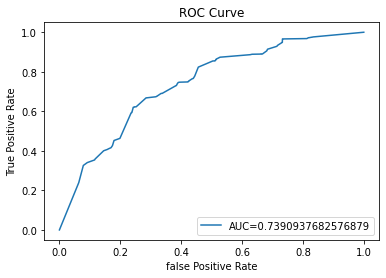

In [849]:
plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)